In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
from jellyfish import hamming_distance

from error_correct import fasta_parse, error_correct

Prototyping error correction methods
===

Load sequence data
---

In [2]:
df = fasta_parse('/Users/williamdewitt/Downloads/S1_collapse-unique.fasta')
df

,sequence,C primer,V primer,abundance,length
0,NNNNNNNNNNNNNNNNNNNNNNNNAGTGTCTCTGGTGGCTCCGTCA...,CHG-R,IGHV4-F,1,420
1,NNNNNNNNNNNNNNNNNNNNNNNNGACATCTACGTTGATTCTTTCA...,CHG-R,IGHV4-F,1965,435
2,NNNNNNNNNNNNNNNNNNNNNNNNAGTGTCTCTGGTGCTTCCATCA...,CHG-R,IGHV4-F,1,428
3,NNNNNNNNNNNNNNNNNNNNNNNNGCTGTCTATGGTGGGTCCTTCA...,CHG-R,IGHV4-F,2037,459
4,NNNNNNNNNNNNNNNNNNNNNNNNAATGTCTCTGGTGGCGCCATCA...,CHG-R,IGHV4-F,2992,456
...,...,...,...,...,...
296894,NNNNNNNNNNNNNNNNNNNNNNNGCCTCTGGGTTCACCGTCAGTAG...,CHG-R,IGHV3-F,1,428
296895,NNNNNNNNNNNNNNNNNNNNNNNGCCTCTGGATTCACCTTCAGTAA...,CHG-R,IGHV3-F,1,425
296896,NNNNNNNNNNNNNNNNNNNNNNNNACTGTCTCTGGTGGCTCCATCA...,CHG-R,IGHV4-F,1,441
296897,NNNNNNNNNNNNNNNNNNNNNNNGCCTCTGGATTCACCTTTAGCGG...,CHG-R,IGHV3-F,1,431


Abundance distribution
---

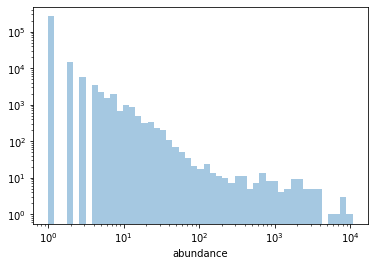

In [3]:
bins = np.logspace(0, np.log10(df.abundance.max()), 50)
sns.distplot(df.abundance, kde=False, bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.show()

V primer distribution
---

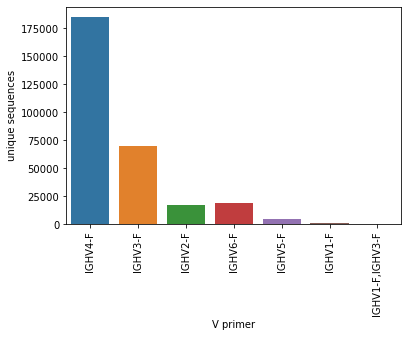

In [4]:
sns.countplot(df['V primer'])
plt.xticks(rotation='vertical')
plt.ylabel('unique sequences')
plt.show()

Length distribution
---

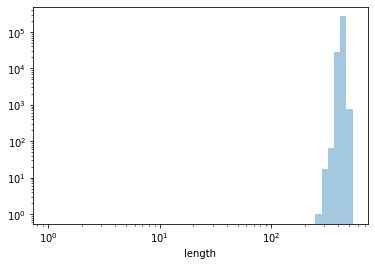

In [5]:
sns.distplot(df.length, kde=False, bins=np.logspace(0, np.log10(df.length.max()), 50))
plt.xscale('log')
plt.yscale('log')
plt.show()

Error correction based on Hamming distance and relative abundance
---

Function for computing a sparse distance matrix. The first level of sparsity is block diagonal by groups with common primers and sequence length. The second level is based on abundance ratio and hamming distance threshold.

In [6]:
df_corrected = error_correct(df, delta_r=1)
df_corrected = error_correct(df_corrected, delta_r=1)
df_corrected = error_correct(df_corrected, delta_r=1)

KeyboardInterrupt: 

In [ ]:
df_corrected

Abundance distribution before and after error correction
---

In [ ]:
print(f'unique sequences before error correction: {len(df)}')
print(f'unique sequences after error correction: {len(df_corrected)}')
print(f'singleton number before error correction: {df.abundance[df.abundance == 1].sum()}')
print(f'singleton number after error correction: {df_corrected.abundance[df_corrected.abundance == 1].sum()}')
print(f'singleton composition before error correction: {df.abundance[df.abundance == 1].sum() / df.abundance.sum():.2%}')
print(f'singleton composition after error correction: {df_corrected.abundance[df_corrected.abundance == 1].sum() / df_corrected.abundance.sum():.2%}')
sns.distplot(df.abundance, kde=False, bins=bins, label='uncorrected')
sns.distplot(df_corrected.abundance, kde=False, bins=bins, label='corrected')
plt.xscale('log')
plt.yscale('symlog')
plt.legend()
plt.show()

In [ ]:
def nearest_neighbor_distance(seq: str, seqs: np.ndarray) -> int:
    d = np.inf
    for ct, seq2 in enumerate(seqs, 1):
        if len(seq) != len(seq2):
            continue
        d_new = hamming_distance(seq, seq2)
        if 0 < d_new < d:
            d = d_new
    return d


Nearest neighbor distances of singletons Vs doubletons ...
---

In [ ]:
size = 1000

In [ ]:
plt.subplot(121, title='before error correction')
plt.hist(np.array([[nearest_neighbor_distance(seq, df.sequence.values) for seq in np.random.choice(df.sequence[df.abundance == 1].values, size)],
                   [nearest_neighbor_distance(seq, df.sequence.values) for seq in np.random.choice(df.sequence[df.abundance == 2].values, size)],
                   [nearest_neighbor_distance(seq, df.sequence.values) for seq in np.random.choice(df.sequence[df.abundance == 3].values, size)]]).T,
         bins=np.logspace(0, 2, 20), label=('singletons', 'doubletons', 'tripletons'))
plt.xlabel('neighbor distance')
plt.xscale('log')
plt.legend()
plt.subplot(122, title='after error correction')
plt.hist(np.array([[nearest_neighbor_distance(seq, df_corrected.sequence.values) for seq in np.random.choice(df_corrected.sequence[df_corrected.abundance == 1].values, size)],
                   [nearest_neighbor_distance(seq, df_corrected.sequence.values) for seq in np.random.choice(df_corrected.sequence[df_corrected.abundance == 2].values, size)],
                   [nearest_neighbor_distance(seq, df_corrected.sequence.values) for seq in np.random.choice(df_corrected.sequence[df_corrected.abundance == 3].values, size)]]).T,
         bins=np.logspace(0, 2, 20), label=('singletons', 'doubletons', 'tripletons'))
plt.xlabel('neighbor distance')
plt.xscale('log')
plt.show()